# Import bibliotek

In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# Wstępna analiza danych

## Wprowadzenie danych, ocena podstawowych parametrów, transformacja danych do dalszej analizy

In [222]:
insurance = pd.read_csv("insurance.csv")

In [223]:
insurance.head()
# Mamy 6 cech potencjalnie opisujących 

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [224]:
insurance.describe()
# Ocena podstawowych statystyk

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [225]:
# przygotowanie danych do modelowania
enc = OneHotEncoder(sparse_output=False).set_output(transform='pandas')
X_to_enc = insurance[['sex','region','smoker']]
dummy_features = enc.fit_transform(X_to_enc)

insurance_enc = pd.concat([insurance,dummy_features], axis=1)[['age', 'bmi', 'children',
       'sex_female', 'sex_male', 'region_northeast', 'region_northwest',
       'region_southeast', 'region_southwest', 'smoker_no', 'smoker_yes', 'charges']]

X_to_model = insurance_enc[['age', 'bmi', 'children',
       'sex_female', 'sex_male', 'region_northeast', 'region_northwest',
       'region_southeast', 'region_southwest', 'smoker_no', 'smoker_yes']]
y_to_model = insurance_enc[['charges']]

insurance_OHE = insurance_enc[['age', 'bmi', 'children',
       'sex_female', 'sex_male', 'region_northeast', 'region_northwest',
       'region_southeast', 'region_southwest', 'smoker_no', 'smoker_yes','charges']]

In [226]:
# dataframe bardziej szczegółowe, do konkretnych widoków

insurance_smoker = insurance.where(insurance["smoker"]=="yes").dropna()
insurance_no_smoker = insurance.where(insurance["smoker"]=="no").dropna()

insurance_southeast = insurance.where(insurance["region"]=="southeast").dropna()
insurance_southwest = insurance.where(insurance["region"]=="southwest").dropna()
insurance_northwest = insurance.where(insurance["region"]=="northwest").dropna()
insurance_northeast = insurance.where(insurance["region"]=="northeast").dropna()

insurance_male = insurance.where(insurance["sex"]=="male").dropna()
insurance_female = insurance.where(insurance["sex"]=="female").dropna()

X_bmi = insurance["bmi"]
X_age = insurance["age"]
y = insurance["charges"]

X_age_smoker = insurance_smoker["age"]
X_bmi_smoker = insurance_smoker["bmi"]
y_smoker = insurance_smoker["charges"]

X_age_no_smoker = insurance_no_smoker["age"]
X_bmi_no_smoker = insurance_no_smoker["bmi"]
y_no_smoker = insurance_no_smoker["charges"]

X_male = insurance_male["age"]
y_male = insurance_male["charges"]

X_female = insurance_female["age"]
y_female = insurance_female["charges"]

X_southeast = insurance_southeast["age"]
y_southeast = insurance_southeast["charges"]

X_southwest = insurance_southwest["age"]
y_southwest = insurance_southwest["charges"]

X_northwest = insurance_northwest["age"]
y_northwest = insurance_northwest["charges"]

X_northeast = insurance_northeast["age"]
y_northeast = insurance_northeast["charges"]

## Ocena dystrybucji i korelacji cech

<Axes: xlabel='charges', ylabel='Count'>

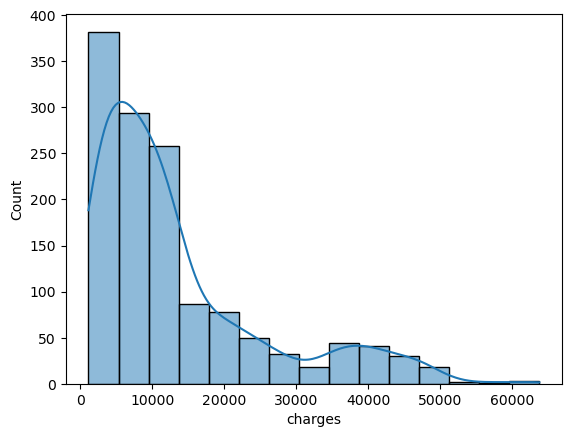

In [227]:
#rozkład kosztu, większość prób ma małe koszty
sns.histplot(data=insurance, x=insurance['charges'], bins=15, kde=True)

<Axes: xlabel='age', ylabel='Count'>

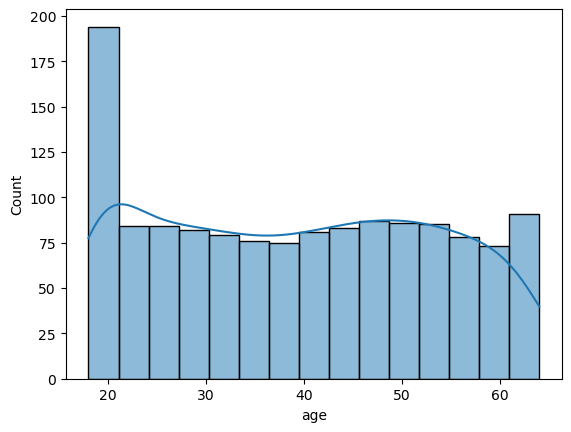

In [228]:
# rozkład wieku, zdecydowanie dużo młodych osób, pozostałe przedziały wyrównane (to może tłumaczyć też dystrybucję kosztów)
sns.histplot(data=insurance, x=insurance['age'], bins=15, kde=True)

<Axes: xlabel='bmi', ylabel='Count'>

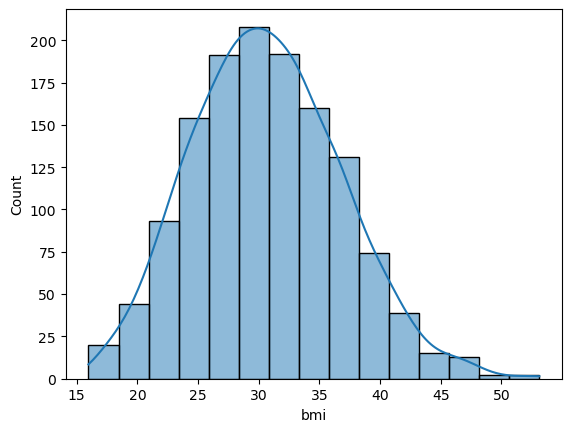

In [229]:
# rozkład bmi, rozkład normalny
sns.histplot(data=insurance, x=insurance['bmi'], bins=15, kde=True)

<Axes: xlabel='children', ylabel='Count'>

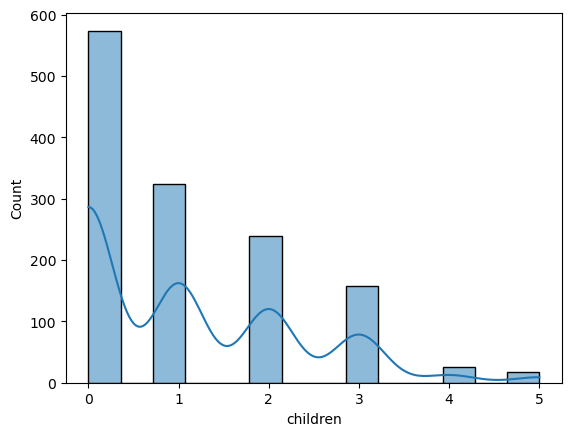

In [230]:
# rozkład l.dzieci większość z 0-1 dzieci
sns.histplot(data=insurance, x=insurance['children'], kde=True)

<Axes: >

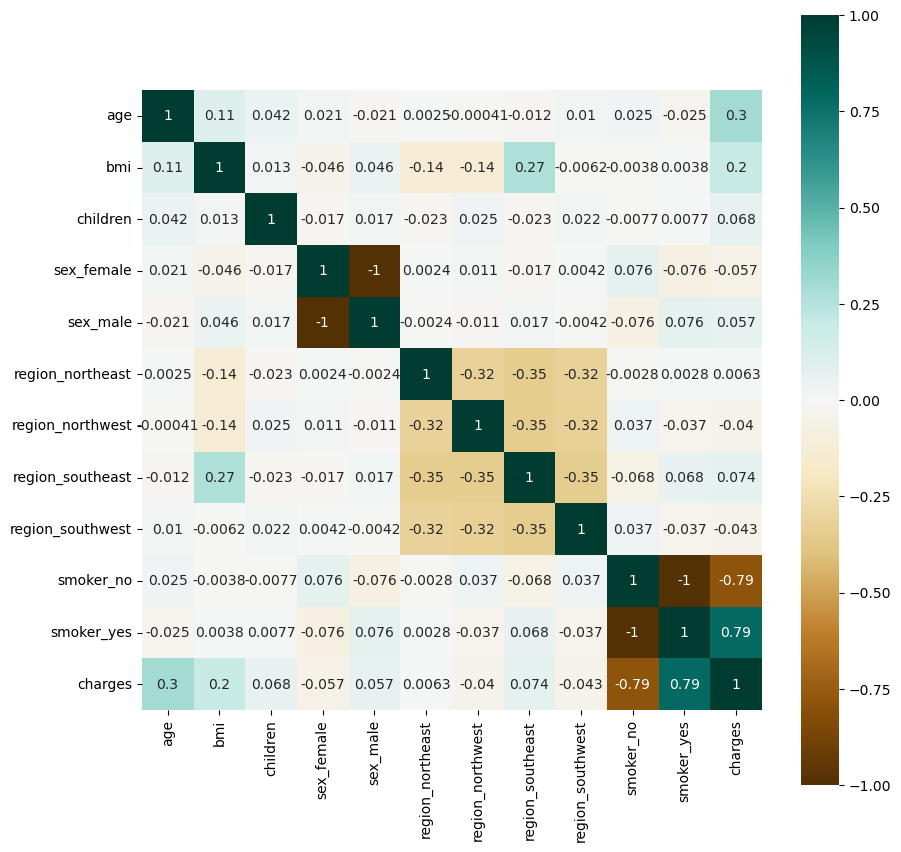

In [249]:
# wstępna ocena korelacji cech, zależność od palenia, wieku, bmi w stopniu znaczącym
corr_matrix = insurance_OHE.corr() #macierz korelacji
plt.figure(1, figsize=(10,10))
sns.heatmap(corr_matrix, cmap='BrBG', center=0, annot=True, square=True)

In [232]:
# w korelacji widać, że 1 region ma większe BMI, dodatkowo widać różnicę w % palących i średnik koszcie
# możliwe, że region też będzie istotny w modelu
insurance['smoker_status1'] = insurance['smoker'].apply(lambda x: 0 if x == 'no' else 1)
insurance['smoker_status2'] = insurance['smoker'].apply(lambda x: 0 if x == 'no' else 1)

region_stats = insurance[['region','age','bmi','charges','smoker_status1','smoker_status2']].groupby(by=['region']).agg(
    {'age':'mean','bmi':'mean','charges':'median','smoker_status1':'count','smoker_status2':'sum'})

region_stats['smoker_%'] = region_stats['smoker_status2'] / region_stats['smoker_status1']
region_stats[['age', 'bmi', 'charges','smoker_%']]

,age,bmi,charges,smoker_%
region,,,,
northeast,39.268519,29.173503,10057.652025,0.206790
northwest,39.196923,29.199785,8965.795750,0.178462
southeast,38.939560,33.355989,9294.131950,0.250000
southwest,39.455385,30.596615,8798.593000,0.178462


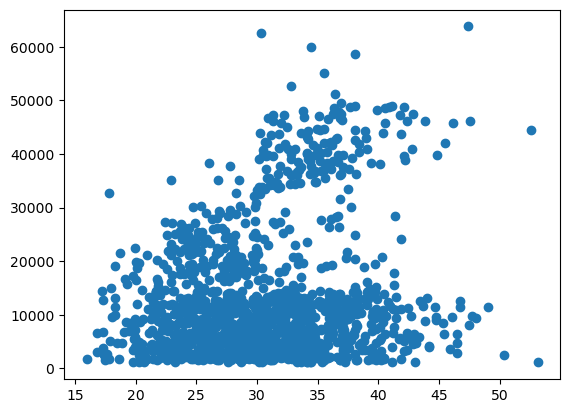

In [233]:
# charges BMI
plt.scatter(X_bmi,y)

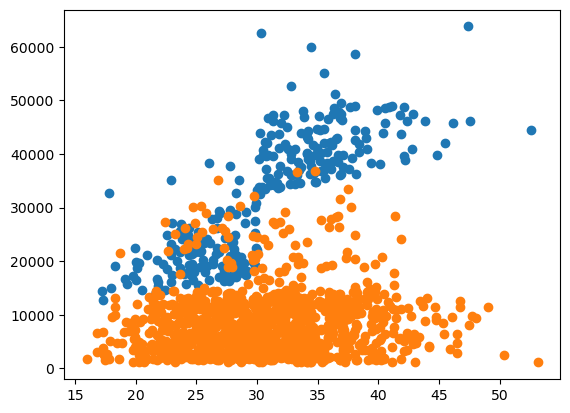

In [234]:
# BMI&SMOKERS
plt.scatter(X_bmi_smoker,y_smoker)
plt.scatter(X_bmi_no_smoker,y_no_smoker)

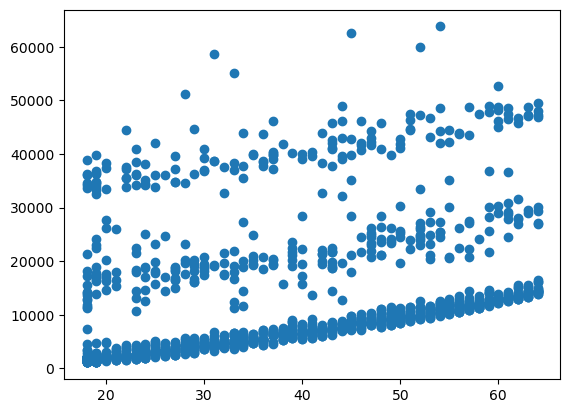

In [235]:
# charges AGE
plt.scatter(X_age,y)

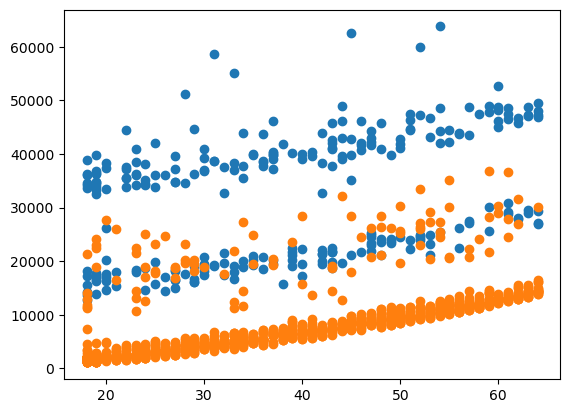

In [236]:
#AGE&SMOKERS
plt.scatter(X_age_smoker,y_smoker)
plt.scatter(X_age_no_smoker,y_no_smoker)

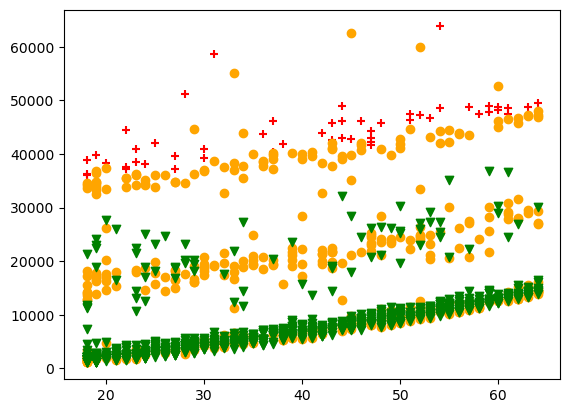

In [237]:
# Ze względu na to, że wg wieku koszty mają trend rosnący, ale wydają się podzielone na 3 klasy
# rozsądne jest odgadnąć klasy, biorąc pod uwagę korelację sprawdzam: lowBMInoSmoker , HighBMIorSmoker , HighBMISmoker
# wydaje się, że wiek, palenie i bmi są najbardziej istotne
def assign_class(row):
    
    if row["bmi"]>36 and row["smoker"] == 'yes':
        return "HighBMI_Smoker"
    elif row["bmi"]>36 or row["smoker"] == 'yes':
        return "HighBMI_or_Smoker"
    elif row["bmi"]<=36 and row["smoker"] == 'no':
        return "LowBMI_NOSmoker"
    else:
        return "err"

insurance["class"] =  insurance.apply(assign_class, axis=1)

insurance_highBMI_smoker = insurance.where(insurance["class"]=="HighBMI_Smoker").dropna()
insurance_highBMI_or_smoker = insurance.where(insurance["class"]=="HighBMI_or_Smoker").dropna()
insurance_lowBMI_nosmoker = insurance.where(insurance["class"]=="LowBMI_NOSmoker").dropna()

X_age_highBMI_smoker = insurance_highBMI_smoker["age"]
X_age_highBMI_or_smoker = insurance_highBMI_or_smoker["age"]
X_age_lowBMI_nosmoker = insurance_lowBMI_nosmoker["age"]

y_age_highBMI_smoker = insurance_highBMI_smoker["charges"]
y_age_highBMI_or_smoker = insurance_highBMI_or_smoker["charges"]
y_age_lowBMI_nosmoker = insurance_lowBMI_nosmoker["charges"]

plt.scatter(X_age_highBMI_smoker,y_age_highBMI_smoker, marker='+', c='red')
plt.scatter(X_age_highBMI_or_smoker,y_age_highBMI_or_smoker, c='orange')
plt.scatter(X_age_lowBMI_nosmoker,y_age_lowBMI_nosmoker, marker='v', c='green')

In [238]:
# Uśrednione dane z wykresu
insurance[['class','charges']].groupby(by='class').mean()

,charges
class,
HighBMI_Smoker,44040.376193
HighBMI_or_Smoker,19602.510326
LowBMI_NOSmoker,8199.434644


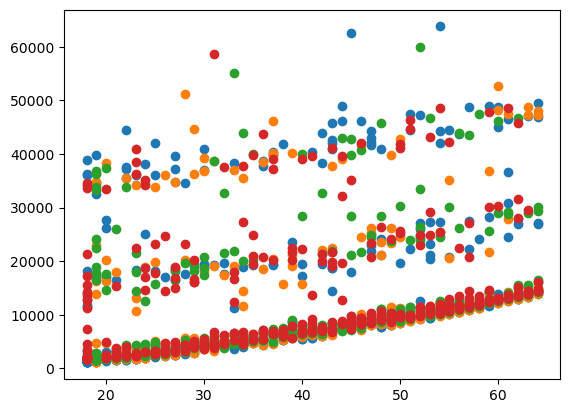

In [239]:
#AGE&REGION (widać, że podzaił wg regionów nie jest bardzo wyraźny w wykresie)
plt.scatter(X_southeast,y_southeast)
plt.scatter(X_southwest,y_southwest)
plt.scatter(X_northwest,y_northwest)
plt.scatter(X_northeast,y_northeast)

## Modelowanie danych

In [240]:
# skalowanie danych
scaler = StandardScaler() 
scaler.fit(X_to_model) 
X_std = scaler.transform(X_to_model)

# podział na zestawy train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_std, y_to_model, test_size=0.33, random_state=42)

In [241]:
# Statystyki modelu Lasso
parameters = [0.1,1,10,100,1000]
lasso_models=[]
for p in parameters:
    model_lasso = Lasso(alpha=p)
    model_lasso.fit(X_train,y_train)
    lasso_models.append(model_lasso)
    print("Dokładność modelu z alfa {} dla zest. uczącego: {:.3f}, dla testowego: {:.3f}".format(
        p,
        model_lasso.score(X_train,y_train),
        model_lasso.score(X_test,y_test)))

Dokładność modelu z alfa 0.1 dla zest. uczącego: 0.746, dla testowego: 0.761
Dokładność modelu z alfa 1 dla zest. uczącego: 0.746, dla testowego: 0.761
Dokładność modelu z alfa 10 dla zest. uczącego: 0.746, dla testowego: 0.761
Dokładność modelu z alfa 100 dla zest. uczącego: 0.745, dla testowego: 0.760
Dokładność modelu z alfa 1000 dla zest. uczącego: 0.723, dla testowego: 0.738


In [242]:
# wagi dla najlepszego modelu Lasso
np.concatenate((X_to_model.columns.to_numpy().reshape(-1,1),lasso_models[0].coef_.reshape(-1,1)),axis=1)

array([['age', 3673.5709543160533],
       ['bmi', 2115.722221461065],
       ['children', 447.90629584508576],
       ['sex_female', -60.47349882444463],
       ['sex_male', 0.0],
       ['region_northeast', 322.16321199711416],
       ['region_northwest', 176.86472174458768],
       ['region_southeast', -59.64330745426096],
       ['region_southwest', -22.062336281323628],
       ['smoker_no', -9564.267769852155],
       ['smoker_yes', 0.0]], dtype=object)

In [243]:
# Statystyki modelu Ridge
parameters = [0.1,1,10,100,1000]
ridge_models=[]
for p in parameters:
    model_ridge = Ridge(alpha=p)
    model_ridge.fit(X_train,y_train)
    ridge_models.append(model_lasso)
    print("Dokładność modelu z alfa {} dla zest. uczącego: {:.3f}, dla testowego: {:.3f}".format(
        p,
        model_ridge.score(X_train,y_train),
        model_ridge.score(X_test,y_test)))

Dokładność modelu z alfa 0.1 dla zest. uczącego: 0.746, dla testowego: 0.761
Dokładność modelu z alfa 1 dla zest. uczącego: 0.746, dla testowego: 0.761
Dokładność modelu z alfa 10 dla zest. uczącego: 0.746, dla testowego: 0.761
Dokładność modelu z alfa 100 dla zest. uczącego: 0.743, dla testowego: 0.758
Dokładność modelu z alfa 1000 dla zest. uczącego: 0.631, dla testowego: 0.643


In [244]:
# wagi dla najlepszego modelu Ridge
np.concatenate((X_to_model.columns.to_numpy().reshape(-1,1),ridge_models[0].coef_.reshape(-1,1)),axis=1)

array([['age', 2785.9852457119696],
       ['bmi', 1068.932081034137],
       ['children', 0.0],
       ['sex_female', -0.0],
       ['sex_male', 0.0],
       ['region_northeast', 0.0],
       ['region_northwest', -0.0],
       ['region_southeast', 0.0],
       ['region_southwest', -0.0],
       ['smoker_no', -8538.05209463874],
       ['smoker_yes', 0.0]], dtype=object)

In [245]:
# Statystyki modelu RFR
parameters = [1,10,20,50,100,500]
rfr_models=[]
for p in parameters:
    rfr = RandomForestRegressor(n_estimators=p)
    rfr.fit(X_train,y_train)
    rfr_models.append(rfr)
    print("Dokładność modelu z max_depth {} dla zest. uczącego: {:.3f}, dla testowego: {:.3f}".format(
        p,
        rfr.score(X_train,y_train),
        rfr.score(X_test,y_test)))

Dokładność modelu z max_depth 1 dla zest. uczącego: 0.882, dla testowego: 0.644
Dokładność modelu z max_depth 10 dla zest. uczącego: 0.967, dla testowego: 0.835
Dokładność modelu z max_depth 20 dla zest. uczącego: 0.976, dla testowego: 0.843
Dokładność modelu z max_depth 50 dla zest. uczącego: 0.975, dla testowego: 0.848
Dokładność modelu z max_depth 100 dla zest. uczącego: 0.977, dla testowego: 0.848
Dokładność modelu z max_depth 500 dla zest. uczącego: 0.978, dla testowego: 0.847


In [246]:
# wagi dla najlepszego modelu RandomForestRegressor
np.concatenate((X_to_model.columns.to_numpy().reshape(-1,1),rfr_models[4].feature_importances_.reshape(-1,1)),axis=1)

array([['age', 0.13714521579499764],
       ['bmi', 0.20672647728259327],
       ['children', 0.018601058326215714],
       ['sex_female', 0.0037808943404524765],
       ['sex_male', 0.0041823342778738205],
       ['region_northeast', 0.0058476963801199575],
       ['region_northwest', 0.004624257068204926],
       ['region_southeast', 0.003327196477287261],
       ['region_southwest', 0.0031713992157132026],
       ['smoker_no', 0.39355475040498694],
       ['smoker_yes', 0.2190387204315548]], dtype=object)